In [1]:
!pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 5.2 MB/s eta 0:00:00


In [2]:
!pip install scikit-learn

In [3]:
!pip install nltk

In [4]:
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report # Import classification_report
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings("ignore")

In [5]:
#loading dataset
df = pd.read_csv(r"/content/Team Brainiac dataset.csv")
df.head()

,Reviewer,Country,StarRatings,Subject,Review,Date_posted
0,Mike Santarcangelo,US,3,"Amazon may be a fine company, but...","Amazon is easy to work with, but they fulfill ...","Tuesday, June 4, 2024"
1,Arthur Riding,GB,5,"Great range of products, generally superior qu...",I have been using AliExpress for well over a y...,"Tuesday, June 4, 2024"
2,UK shopper Val,GB,5,Good!,"A good, customer-centric marketplace. But neve...","Monday, June 3, 2024"
3,Jim Corkery,CA,1,I purchased an Android Tesla style…,I purchased an Android Tesla style radio.\nAft...,"Sunday, June 2, 2024"
4,chris bardin,IE,1,They are an absolute con job dont waste…,They are an absolute con job dont waste your m...,"Tuesday, June 4, 2024"


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Reviewer     11997 non-null  object
 1   Country      11997 non-null  object
 2   StarRatings  12000 non-null  int64 
 3   Subject      12000 non-null  object
 4   Review       11161 non-null  object
 5   Date_posted  12000 non-null  object
dtypes: int64(1), object(5)
memory usage: 562.6+ KB


In [7]:
df.shape

(12000, 6)

In [8]:
df['Date_posted'] =pd.to_datetime(df['Date_posted'])

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Reviewer     11997 non-null  object        
 1   Country      11997 non-null  object        
 2   StarRatings  12000 non-null  int64         
 3   Subject      12000 non-null  object        
 4   Review       11161 non-null  object        
 5   Date_posted  12000 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 562.6+ KB


In [10]:
df['Day'] = df['Date_posted'].dt.day
df['Month'] = df['Date_posted'].dt.strftime('%b')
df['Year'] = df['Date_posted'].dt.year

In [11]:
# investigate the missing data
df.isnull().sum()

,0
Reviewer,3
Country,3
StarRatings,0
Subject,0
Review,839
Date_posted,0
Day,0
Month,0
Year,0


In [12]:
df.fillna({'Reviewer':'Unknown', 'Country':'Unknown'}, inplace=True)

In [13]:
df.duplicated().sum()

0

In [14]:
# Check for null values in the "Review" column
print("Number of null values in 'Review' column before replacement:", df['Review'].isnull().sum())

Number of null values in 'Review' column before replacement: 839


In [15]:
# Replace null values in "Review" column with corresponding values from the "Subject" column
df['Review'].fillna(df['Subject'], inplace=True)

In [16]:
# Verify that null values have been replaced
print("Number of null values in 'Review' column after replacement:", df['Review'].isnull().sum())

Number of null values in 'Review' column after replacement: 0


In [17]:
# investigate the missing data
df.isnull().sum()

,0
Reviewer,0
Country,0
StarRatings,0
Subject,0
Review,0
Date_posted,0
Day,0
Month,0
Year,0


In [18]:
df.head(200)

,Reviewer,Country,StarRatings,Subject,Review,Date_posted,Day,Month,Year
0,Mike Santarcangelo,US,3,"Amazon may be a fine company, but...","Amazon is easy to work with, but they fulfill ...",2024-06-04,4,Jun,2024
1,Arthur Riding,GB,5,"Great range of products, generally superior qu...",I have been using AliExpress for well over a y...,2024-06-04,4,Jun,2024
2,UK shopper Val,GB,5,Good!,"A good, customer-centric marketplace. But neve...",2024-06-03,3,Jun,2024
3,Jim Corkery,CA,1,I purchased an Android Tesla style…,I purchased an Android Tesla style radio.\nAft...,2024-06-02,2,Jun,2024
4,chris bardin,IE,1,They are an absolute con job dont waste…,They are an absolute con job dont waste your m...,2024-06-04,4,Jun,2024
...,...,...,...,...,...,...,...,...,...
195,klant,NL,5,"ok,zoals in de advertentie",good product,2024-05-30,30,May,2024
196,Andrzej,GB,5,They arrived at the promised time.,Very good quiet tires.,2024-05-25,25,May,2024
197,Aleksejs Lasmans,LV,5,Responsive company,Responsive company. Operational work.,2024-05-25,25,May,2024
198,Benjamin Pesantes,PE,5,great!!!!!,great!!!!!,2024-05-25,25,May,2024


In [19]:
df.columns

Index(['Reviewer', 'Country', 'StarRatings', 'Subject', 'Review',
       'Date_posted', 'Day', 'Month', 'Year'],
      dtype='object')

### **EXPLORATORY DATA ANALYSIS**

In [20]:
!pip install dython

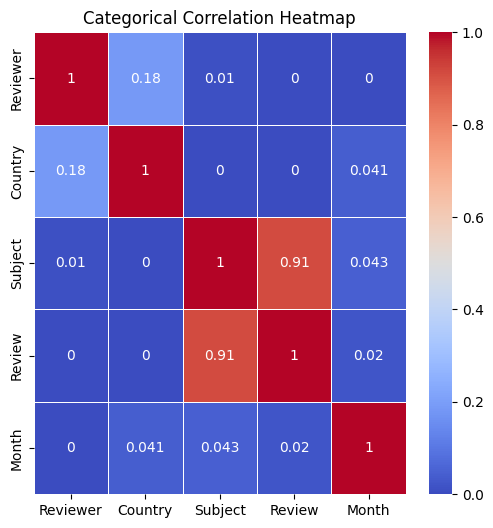

In [21]:
from dython.nominal import cramers_v
# Calculate Cramer's V statistic for pairwise correlation between categorical variables
categorical_columns = df.select_dtypes(include=['object']).columns
correlation_matrix = pd.DataFrame(index=categorical_columns, columns=categorical_columns)

for col1 in categorical_columns:
    for col2 in categorical_columns:
        correlation_matrix.loc[col1, col2] = cramers_v(df[col1], df[col2])
        # Plot the heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(correlation_matrix.astype(float), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Categorical Correlation Heatmap')
plt.show()

**# UNIVARIATE ANALYSIS**

<Figure size 1000x600 with 0 Axes>

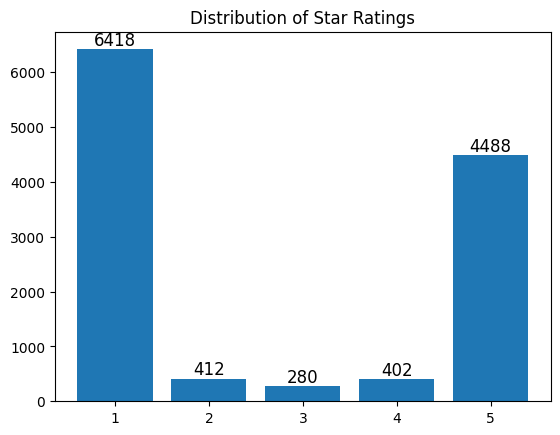

In [22]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))  # Set the figure size
star_counts = df['StarRatings'].value_counts()

# Create the bar plot and get the Axes object
fig, ax = plt.subplots()  # Create a figure and an axes object
star_plot = ax.bar(star_counts.index, star_counts.values)  # Use ax.bar instead of plt.bar

# Annotate the count on each bar
for p in star_plot.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2, p.get_height()),  # Use ax.annotate
                ha='center', va='bottom', fontsize=12)


plt.title('Distribution of Star Ratings')
plt.show()  # Display the plot

<Figure size 1000x600 with 0 Axes>

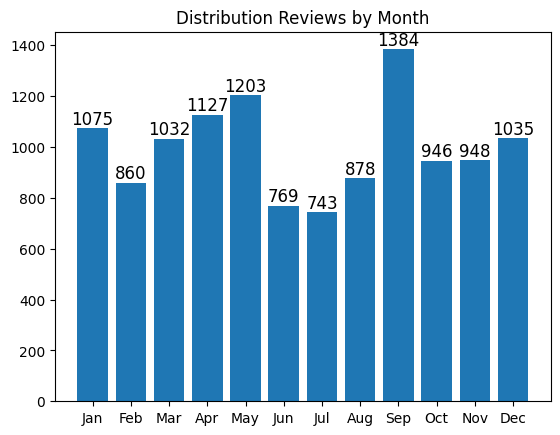

In [23]:
# Define the order of the months
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Count the occurrences of each month and reindex to the correct order
star_counts = df['Month'].value_counts().reindex(month_order, fill_value=0)

plt.figure(figsize=(10, 6))  # Set the figure size

# Create the bar plot and get the Axes object
fig, ax = plt.subplots()  # Create a figure and an axes object
star_plot = ax.bar(star_counts.index, star_counts.values)  # Use ax.bar instead of plt.bar

# Annotate the count on each bar
for p in star_plot.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2, p.get_height()),  # Use ax.annotate
                ha='center', va='bottom', fontsize=12)

plt.title('Distribution Reviews by Month')
plt.show()  # Display the plot

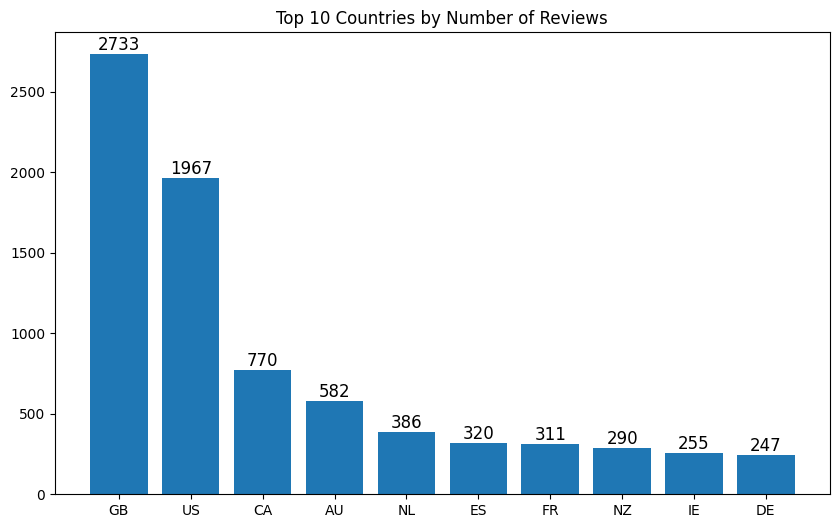

In [24]:
import matplotlib.pyplot as plt

# Get the top 10 countries by the number of reviews
star_counts = df['Country'].value_counts().nlargest(10)

# Create the bar plot and get the Axes object
fig, ax = plt.subplots(figsize=(10, 6))  # Set the figure size

# Plot the bar chart for the top 10 countries
star_plot = ax.bar(star_counts.index, star_counts.values)  # Use ax.bar instead of plt.bar

# Annotate the count on each bar
for p in star_plot.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2, p.get_height()),  # Use ax.annotate
                ha='center', va='bottom', fontsize=12)

plt.title('Top 10 Countries by Number of Reviews')
plt.show()  # Display the plot


<Figure size 1000x600 with 0 Axes>

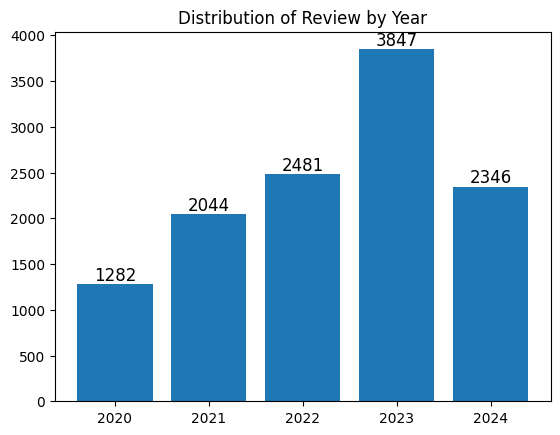

In [25]:
plt.figure(figsize=(10, 6))  # Set the figure size
star_counts = df['Year'].value_counts()

# Create the bar plot and get the Axes object
fig, ax = plt.subplots()  # Create a figure and an axes object
star_plot = ax.bar(star_counts.index, star_counts.values)  # Use ax.bar instead of plt.bar

# Annotate the count on each bar
for p in star_plot.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2, p.get_height()),  # Use ax.annotate
                ha='center', va='bottom', fontsize=12)


plt.title('Distribution of Review by Year')
plt.show()  # Display the plot

**# BIVARIATE ANALYSIS**

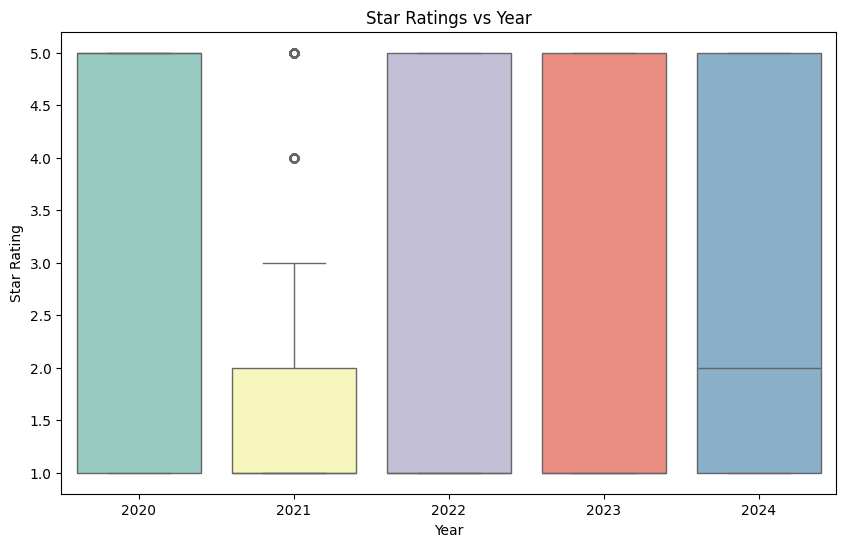

In [26]:
# Bivariate Analysis
## Star Ratings vs Country
plt.figure(figsize=(10, 6))
sns.boxplot(x='Year', y='StarRatings', data=df, palette='Set3')
plt.title('Star Ratings vs Year')
plt.xlabel('Year')
plt.ylabel('Star Rating')
plt.show()

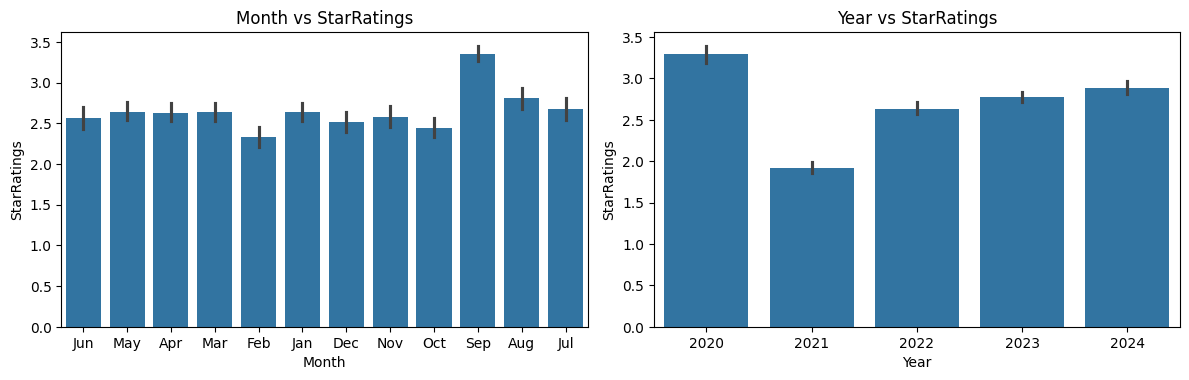

In [27]:
# Visualize relationships between churn and some key Numerical features
plt.figure(figsize=(12, 7))

# Plot churn vs. paperless billing
plt.subplot(2, 2, 1)
sns.barplot(data=df, x='Month', y='StarRatings')
plt.title('Month vs StarRatings')

# Plot churn vs. paperless billing
plt.subplot(2, 2, 2)
sns.barplot(data=df, x='Year', y='StarRatings')
plt.title('Year vs StarRatings')

plt.tight_layout()
plt.show()

<Axes: xlabel='Month', ylabel='StarRatings'>

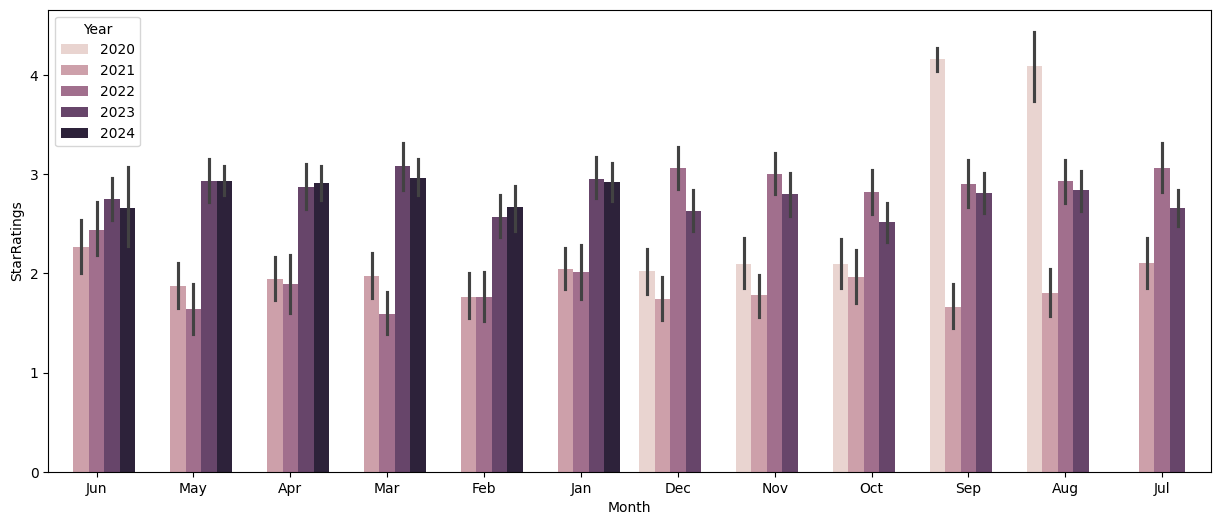

In [28]:
import seaborn as sb
plt.figure(figsize=(15, 6))
sb.barplot(x='Month', y='StarRatings',hue='Year',data=df)

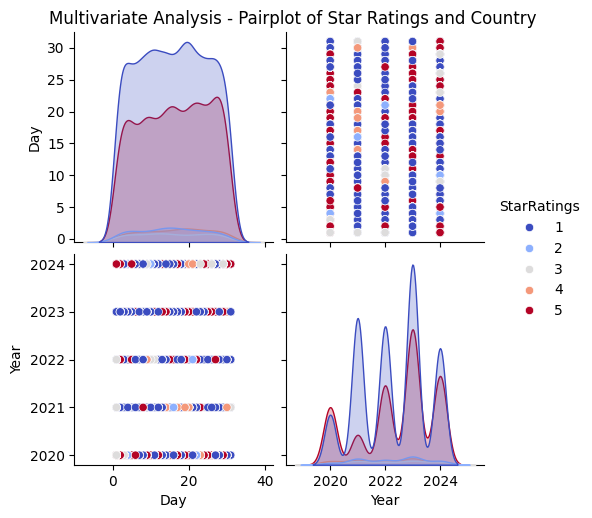

In [29]:
# Multivariate Analysis
## Pairplot with Star Ratings and Countries
sns.pairplot(df, hue='StarRatings', palette='coolwarm')
plt.suptitle('Multivariate Analysis - Pairplot of Star Ratings and Country', y=1.02)
plt.show()

In [30]:
df['Review'].iloc[3]

'I purchased an Android Tesla style radio.\nAfter I installed it there was no sound nor did the steering wheel radio controls work.\nAliExpress kept saying it was not installed correctly. I had the install verified with their PDF file I was sent, all was correct. AliExpress website states there is a 365 day warranty on electronics, they do not honour the warranty.\nBUYER BEWARE. My advise is stay away from them.\nJim Corkery'

### **Step 1: Data Preprocessing**

In [31]:
# 1. Text Cleaning
def clean_text(text):
    text = str(text) # Cast the input to a string to handle potential non-string values
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters and numbers
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'http\S+|www.\S+', '', text)  # Remove URLs
    text = re.sub(r'\b\d+\b', '', text)  # Remove numbers
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = text.lower().strip()  # Convert to lowercase and strip whitespace
    return text

df['Cleaned_Review'] = df['Review'].apply(clean_text)

In [32]:
df['Cleaned_Review']

,Cleaned_Review
0,amazon is easy to work with but they fulfill t...
1,i have been using aliexpress for well over a y...
2,a good customercentric marketplace but neverth...
3,i purchased an android tesla style radio\nafte...
4,they are an absolute con job dont waste your m...
...,...
11995,im happy with the out come thank you
11996,excellent quality
11997,i ordered items from aliexpress and two selle...
11998,great platform for doing business with vendors...


In [33]:
df.head(200)

,Reviewer,Country,StarRatings,Subject,Review,Date_posted,Day,Month,Year,Cleaned_Review
0,Mike Santarcangelo,US,3,"Amazon may be a fine company, but...","Amazon is easy to work with, but they fulfill ...",2024-06-04,4,Jun,2024,amazon is easy to work with but they fulfill t...
1,Arthur Riding,GB,5,"Great range of products, generally superior qu...",I have been using AliExpress for well over a y...,2024-06-04,4,Jun,2024,i have been using aliexpress for well over a y...
2,UK shopper Val,GB,5,Good!,"A good, customer-centric marketplace. But neve...",2024-06-03,3,Jun,2024,a good customercentric marketplace but neverth...
3,Jim Corkery,CA,1,I purchased an Android Tesla style…,I purchased an Android Tesla style radio.\nAft...,2024-06-02,2,Jun,2024,i purchased an android tesla style radio\nafte...
4,chris bardin,IE,1,They are an absolute con job dont waste…,They are an absolute con job dont waste your m...,2024-06-04,4,Jun,2024,they are an absolute con job dont waste your m...
...,...,...,...,...,...,...,...,...,...,...
195,klant,NL,5,"ok,zoals in de advertentie",good product,2024-05-30,30,May,2024,good product
196,Andrzej,GB,5,They arrived at the promised time.,Very good quiet tires.,2024-05-25,25,May,2024,very good quiet tires
197,Aleksejs Lasmans,LV,5,Responsive company,Responsive company. Operational work.,2024-05-25,25,May,2024,responsive company operational work
198,Benjamin Pesantes,PE,5,great!!!!!,great!!!!!,2024-05-25,25,May,2024,great


In [34]:
#summary statistics
df.describe()

,StarRatings,Date_posted,Day,Year
count,12000.000000,12000,12000.000000,12000.000000
mean,2.677500,2022-10-29 06:12:21.600000,16.008417,2022.327583
min,1.000000,2020-08-27 00:00:00,1.000000,2020.000000
25%,1.000000,2021-10-29 00:00:00,9.000000,2021.000000
50%,1.000000,2023-01-17 00:00:00,16.000000,2023.000000
75%,5.000000,2023-11-03 00:00:00,24.000000,2023.000000
max,5.000000,2024-06-04 00:00:00,31.000000,2024.000000
std,1.897224,NaN,8.800453,1.262170


In [35]:
!pip install wordcloud
from wordcloud import WordCloud

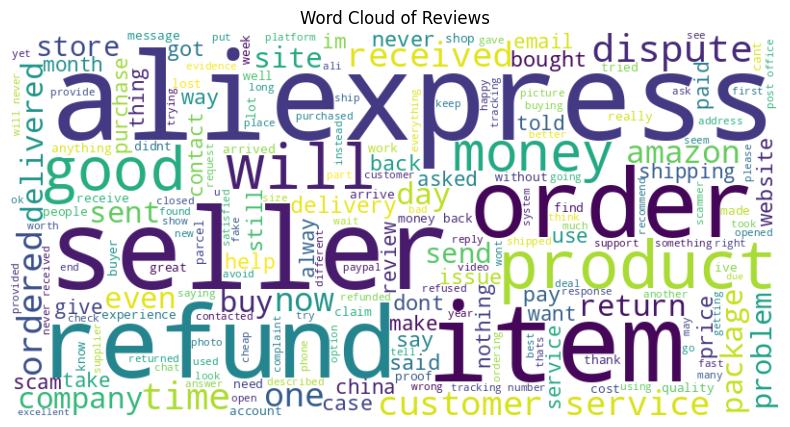

In [36]:
# Example: Most common words
from wordcloud import WordCloud

all_reviews = ' '.join(df['Cleaned_Review'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_reviews)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Reviews')
plt.show()

In [37]:
# Count the frequency of each word
from collections import Counter
word_counts = Counter(all_reviews.split())
sorted_word_counts = word_counts.most_common()    ## Arrange in descending order
sorted_word_counts

[('the', 33586),
 ('i', 24588),
 ('to', 23015),
 ('and', 22365),
 ('a', 17575),
 ('is', 10351),
 ('they', 10248),
 ('of', 10069),
 ('it', 9655),
 ('not', 9108),
 ('for', 9078),
 ('you', 8961),
 ('aliexpress', 8427),
 ('my', 7769),
 ('that', 7564),
 ('in', 7169),
 ('with', 7080),
 ('have', 6931),
 ('was', 6886),
 ('from', 6086),
 ('this', 5908),
 ('but', 5597),
 ('on', 5558),
 ('me', 5164),
 ('seller', 4730),
 ('refund', 4715),
 ('are', 4409),
 ('no', 4230),
 ('as', 4022),
 ('order', 3760),
 ('item', 3723),
 ('will', 3700),
 ('be', 3545),
 ('so', 3476),
 ('them', 3397),
 ('if', 3352),
 ('get', 3249),
 ('money', 3192),
 ('very', 3178),
 ('never', 3054),
 ('service', 2905),
 ('or', 2868),
 ('customer', 2861),
 ('all', 2839),
 ('items', 2835),
 ('your', 2825),
 ('good', 2812),
 ('do', 2740),
 ('an', 2694),
 ('at', 2602),
 ('their', 2598),
 ('had', 2589),
 ('time', 2553),
 ('product', 2536),
 ('dont', 2532),
 ('received', 2412),
 ('when', 2375),
 ('dispute', 2334),
 ('been', 2286),
 ('deliv

In [38]:
# Get the top 10 most common words
top_10_words = sorted_word_counts[:20]  # Slice the list to get the top 10
top_10_words

[('the', 33586),
 ('i', 24588),
 ('to', 23015),
 ('and', 22365),
 ('a', 17575),
 ('is', 10351),
 ('they', 10248),
 ('of', 10069),
 ('it', 9655),
 ('not', 9108),
 ('for', 9078),
 ('you', 8961),
 ('aliexpress', 8427),
 ('my', 7769),
 ('that', 7564),
 ('in', 7169),
 ('with', 7080),
 ('have', 6931),
 ('was', 6886),
 ('from', 6086)]

In [39]:
# 2. Tokenization  #STOPWORSD are words that do not necessarily convey meaning
nltk.download('punkt')
nltk.download('stopwords') # Fixed the typo here
stop_words = set(stopwords.words('english'))
# convert words in lower case: if in stopwords dnt include in my_list, if nt in stopwords put it in my list
df['Cleaned_Toknize']=df['Cleaned_Review'].apply(lambda x: [word for word in word_tokenize(x) if word.lower() not in stop_words])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [40]:
stopwords.words() # to display entire stopwords library

['إذ',
 'إذا',
 'إذما',
 'إذن',
 'أف',
 'أقل',
 'أكثر',
 'ألا',
 'إلا',
 'التي',
 'الذي',
 'الذين',
 'اللاتي',
 'اللائي',
 'اللتان',
 'اللتيا',
 'اللتين',
 'اللذان',
 'اللذين',
 'اللواتي',
 'إلى',
 'إليك',
 'إليكم',
 'إليكما',
 'إليكن',
 'أم',
 'أما',
 'أما',
 'إما',
 'أن',
 'إن',
 'إنا',
 'أنا',
 'أنت',
 'أنتم',
 'أنتما',
 'أنتن',
 'إنما',
 'إنه',
 'أنى',
 'أنى',
 'آه',
 'آها',
 'أو',
 'أولاء',
 'أولئك',
 'أوه',
 'آي',
 'أي',
 'أيها',
 'إي',
 'أين',
 'أين',
 'أينما',
 'إيه',
 'بخ',
 'بس',
 'بعد',
 'بعض',
 'بك',
 'بكم',
 'بكم',
 'بكما',
 'بكن',
 'بل',
 'بلى',
 'بما',
 'بماذا',
 'بمن',
 'بنا',
 'به',
 'بها',
 'بهم',
 'بهما',
 'بهن',
 'بي',
 'بين',
 'بيد',
 'تلك',
 'تلكم',
 'تلكما',
 'ته',
 'تي',
 'تين',
 'تينك',
 'ثم',
 'ثمة',
 'حاشا',
 'حبذا',
 'حتى',
 'حيث',
 'حيثما',
 'حين',
 'خلا',
 'دون',
 'ذا',
 'ذات',
 'ذاك',
 'ذان',
 'ذانك',
 'ذلك',
 'ذلكم',
 'ذلكما',
 'ذلكن',
 'ذه',
 'ذو',
 'ذوا',
 'ذواتا',
 'ذواتي',
 'ذي',
 'ذين',
 'ذينك',
 'ريث',
 'سوف',
 'سوى',
 'شتان',
 'عدا',
 'عسى',
 'عل'

In [41]:
df['Cleaned_Toknize'].head(10)

,Cleaned_Toknize
0,"[amazon, easy, work, fulfill, orders, via, rd,..."
1,"[using, aliexpress, well, year, consistently, ..."
2,"[good, customercentric, marketplace, neverthel..."
3,"[purchased, android, tesla, style, radio, inst..."
4,"[absolute, con, job, dont, waste, money, scamm..."
5,"[sinoscogo, best, company, deal, many, years, ..."
6,"[careful, scammers, use, instagram, facebook, ..."
7,"[aliexpress, quick, efficient, take, money, en..."
8,"[order, delivered, mailbox, peddler, expressth..."
9,"[reputable, purchasing, platform, dont, get, p..."


In [42]:
df['Cleaned_Toknize'].iloc[2] #Presentation of row 3 after STOPWORDS have been removed

['good',
 'customercentric',
 'marketplace',
 'nevertheless',
 'need',
 'think',
 'doublecheck',
 'making',
 'deal',
 'time',
 'time',
 'sellers',
 'try',
 'cheat',
 'sell',
 'goods',
 'match',
 'description',
 'several',
 'times',
 'expensive',
 'sellers',
 'prices',
 'sometimes',
 'higher',
 'buy',
 'locally',
 'uk',
 'ebay',
 'seems',
 'like',
 'nonsense',
 'glad',
 'negative',
 'cases',
 'happen',
 'often',
 'contacting',
 'administration',
 'least',
 'experience',
 'disputable',
 'situations',
 'resolved',
 'favour']

In [43]:
df['Cleaned_Rev'] = df['Cleaned_Toknize'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)
df['Cleaned_Rev'].head(10)

,Cleaned_Rev
0,amazon easy work fulfill orders via rd party c...
1,using aliexpress well year consistently impres...
2,good customercentric marketplace nevertheless ...
3,purchased android tesla style radio installed ...
4,absolute con job dont waste money scammers rec...
5,sinoscogo best company deal many years done bu...
6,careful scammers use instagram facebook photos...
7,aliexpress quick efficient take money end prov...
8,order delivered mailbox peddler expressthis de...
9,reputable purchasing platform dont get paid of...


In [44]:
df

,Reviewer,Country,StarRatings,Subject,Review,Date_posted,Day,Month,Year,Cleaned_Review,Cleaned_Toknize,Cleaned_Rev
0,Mike Santarcangelo,US,3,"Amazon may be a fine company, but...","Amazon is easy to work with, but they fulfill ...",2024-06-04,4,Jun,2024,amazon is easy to work with but they fulfill t...,"[amazon, easy, work, fulfill, orders, via, rd,...",amazon easy work fulfill orders via rd party c...
1,Arthur Riding,GB,5,"Great range of products, generally superior qu...",I have been using AliExpress for well over a y...,2024-06-04,4,Jun,2024,i have been using aliexpress for well over a y...,"[using, aliexpress, well, year, consistently, ...",using aliexpress well year consistently impres...
2,UK shopper Val,GB,5,Good!,"A good, customer-centric marketplace. But neve...",2024-06-03,3,Jun,2024,a good customercentric marketplace but neverth...,"[good, customercentric, marketplace, neverthel...",good customercentric marketplace nevertheless ...
3,Jim Corkery,CA,1,I purchased an Android Tesla style…,I purchased an Android Tesla style radio.\nAft...,2024-06-02,2,Jun,2024,i purchased an android tesla style radio\nafte...,"[purchased, android, tesla, style, radio, inst...",purchased android tesla style radio installed ...
4,chris bardin,IE,1,They are an absolute con job dont waste…,They are an absolute con job dont waste your m...,2024-06-04,4,Jun,2024,they are an absolute con job dont waste your m...,"[absolute, con, job, dont, waste, money, scamm...",absolute con job dont waste money scammers rec...
...,...,...,...,...,...,...,...,...,...,...,...,...
11995,Conn,US,5,I'm happy with the out come,I'm happy with the out come. Thank you,2020-08-27,27,Aug,2020,im happy with the out come thank you,"[im, happy, come, thank]",im happy come thank
11996,Emil Ivanov,BG,5,exlent,Excellent quality,2020-08-27,27,Aug,2020,excellent quality,"[excellent, quality]",excellent quality
11997,David Cyr,CA,1,Sellers cancelled shipments,I ordered 6 items from AliExpress and two sell...,2020-08-27,27,Aug,2020,i ordered items from aliexpress and two selle...,"[ordered, items, aliexpress, two, sellers, can...",ordered items aliexpress two sellers cancelled...
11998,Jim Colton,US,5,Great platform.,Great platform for doing business with vendors...,2020-08-27,27,Aug,2020,great platform for doing business with vendors...,"[great, platform, business, vendors, would, ne...",great platform business vendors would never ab...


### **Step 2: Feature Engineering**
- TfidfVectorizer: This step converts the cleaned text reviews into a TF-IDF (Term Frequency-Inverse Document Frequency) matrix, which is a numerical representation of the text data. TF-IDF weighs the importance of a word in a document relative to how frequently it appears across multiple documents.
- Input Features (df['Cleaned_Review'])
- Target Variable (df['Sentiment']): These are the true sentiment labels for the reviews.

In [45]:
# 1. Bag of Words Vectors
vectorizer = CountVectorizer()
X_bow = vectorizer.fit_transform(df['Cleaned_Rev'])
print(X_bow.toarray()) #prints the BOW FEATURE MATRIX

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [46]:
# Bag of Words
bow_vectorizer = CountVectorizer()
bow_features = bow_vectorizer.fit_transform(df['Cleaned_Rev'])
print(bow_features.shape)

(12000, 21618)


In [47]:
# 2. TF-IDF
tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(df['Cleaned_Rev'])
print(X_tfidf.shape)

# Target variable based on Star Ratings (assuming >3 is positive, else negative)
df['Sentiment'] = df['StarRatings'].apply(lambda x: 1 if x > 3 else 0)

(12000, 21618)


In [48]:
X_tfidf = tfidf.fit_transform(df['Cleaned_Rev']) # Pass the column data, not the column name
print(X_tfidf.toarray()) #prints the TF-IDF FEATURE MATRIX

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


### **Step 3: Model Development**
- MultinomialNB: This step applies the Naive Bayes classifier to the TF-IDF features generated in the previous step. The alpha parameter is a smoothing factor.
- This also includes hyperparameter tuning for the Naive Bayes model and threshold adjustment for the Vader sentiment analysis model.

In [49]:
#MODEL ON TF-IDF
# Splitting the dataset
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_tfidf, df['Sentiment'], test_size=0.2, random_state=42)

# Train a Naive Bayes model
model = MultinomialNB()
model.fit(X_train_tfidf, y_train)

# Prediction
y_pred = model.predict(X_test_tfidf)

# Model performance
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

#print(f"Naive Bayes Accuracy: {accuracy:.2f}")
#print(f"Naive Bayes F1 Score: {f1:.2f}")

# Optional: Hyperparameter tuning for Naive Bayes
parameters = {'alpha': [0.1, 0.5, 1.0]}
grid_search = GridSearchCV(model, parameters, scoring='f1', cv=5)
grid_search.fit(X_train_tfidf, y_train)
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test_tfidf)

# Re-evaluate with the best model
best_accuracy = accuracy_score(y_test, y_pred_best)
best_f1 = f1_score(y_test, y_pred_best)

#print(f"Best Model Accuracy: {best_accuracy:.2f}")
#print(f"Best Model F1 Score: {best_f1:.2f}")

In [50]:
#MODEL ON BAG OF WORDS
# Splitting the dataset
X_train_bow, X_test_bow, y_train, y_test = train_test_split(X_bow, df['Sentiment'], test_size=0.2, random_state=42)

# Train a Naive Bayes model
model = MultinomialNB()
model.fit(X_train_bow, y_train)

# Prediction
y_pred = model.predict(X_test_bow)

# Model performance
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

#print(f"Naive Bayes Accuracy: {accuracy:.2f}")
#print(f"Naive Bayes F1 Score: {f1:.2f}")

# Optional: Hyperparameter tuning for Naive Bayes
parameters = {'alpha': [0.1, 0.5, 1.0]}
grid_search = GridSearchCV(model, parameters, scoring='f1', cv=5)
grid_search.fit(X_train_bow, y_train)
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test_bow)

# Re-evaluate with the best model
best_accuracy = accuracy_score(y_test, y_pred_best)
best_f1 = f1_score(y_test, y_pred_best)

#print(f"Best Model Accuracy: {best_accuracy:.2f}")
#print(f"Best Model F1 Score: {best_f1:.2f}")

**using a pre-trained model, Vader, for sentiment analysis**

In [51]:
# Using Vader for sentiment analysis
import nltk
nltk.download('vader_lexicon')
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()


# Calculate sentiment scores using VADER
df['Vader_sentiment'] = df['Cleaned_Rev'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

# Convert sentiment scores to binary labels (1 for positive, 0 for negative)
df['Vader_Sentiment'] = df['Vader_sentiment'].apply(lambda x: 1 if x > 0 else 0)

# Evaluating Vader performance
vader_accuracy = accuracy_score(df['Sentiment'], df['Vader_Sentiment'])
vader_f1 = f1_score(df['Sentiment'], df['Vader_Sentiment'], average='macro') # Change average to 'macro' or another suitable option
vader_precision = precision_score(df['Sentiment'], df['Vader_Sentiment'], average='macro') # Use 'macro' or a suitable average
vader_recall = recall_score(df['Sentiment'], df['Vader_Sentiment'], average='macro') # Use 'macro' or a suitable average


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


### **Step 4: Model Evaluation**

In [52]:
# 1. Model performance for TF-IDF USING NAIVE BAYES
accuracy_tfidf = accuracy_score(y_test, y_pred)
f1_tfidf = f1_score(y_test, y_pred)
Precision_tfidf = precision_score(y_test, y_pred)
Recall_tfidf = recall_score(y_test, y_pred)

print(f"Accuracy: {accuracy_tfidf:.2f}")
print(f"F1 Score: {f1_tfidf:.2f}")
print(f"Precision: {Precision_tfidf:.2f}")
print(f"Recall: {Recall_tfidf:.2f}")

Accuracy: 0.92
F1 Score: 0.90
Precision: 0.91
Recall: 0.90


In [53]:
# 1.1. Optional: Hyperparameter tuning of Model performance for TF-IDF USING NAIVE BAYES
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report # Import classification_report
from sklearn.model_selection import GridSearchCV
parameters = {'alpha': [0.1, 0.5, 1.0]}
grid_search = GridSearchCV(model, parameters, scoring='f1', cv=5)
grid_search.fit(X_train_tfidf, y_train)

best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test_tfidf)

# Re-evaluate with the best model
best_accuracy_tfidf = accuracy_score(y_test, y_pred_best)
best_f1_tfidf = f1_score(y_test, y_pred_best)
best_precision_tfidf = precision_score(y_test, y_pred_best) # Calculate best_precision
best_recall_tfidf = recall_score(y_test, y_pred_best) # Calculate best_recall

print(f"Best Model Accuracy: {best_accuracy_tfidf:.2f}")
print(f"Best Model F1 Score: {best_f1_tfidf:.2f}")
print(f"Best Model Precision: {best_precision_tfidf:.2f}") # Now you can print best_precision
print(f"Best Model Recall: {best_recall_tfidf:.2f}")
print(f"Best Model Confusion Matrix:\n{confusion_matrix(y_test, y_pred_best)}")
print(f"Best Model Classification Report:\n{classification_report(y_test, y_pred_best)}") # Now this line should work

Best Model Accuracy: 0.92
Best Model F1 Score: 0.90
Best Model Precision: 0.94
Best Model Recall: 0.88
Best Model Confusion Matrix:
[[1363   59]
 [ 122  856]]
Best Model Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      1422
           1       0.94      0.88      0.90       978

    accuracy                           0.92      2400
   macro avg       0.93      0.92      0.92      2400
weighted avg       0.93      0.92      0.92      2400



In [54]:
# 2. Model performance for BAG OF WORDS USING NAIVE BAYES
accuracy_bow = accuracy_score(y_test, y_pred)
f1_bow = f1_score(y_test, y_pred)
Precision_bow = precision_score(y_test, y_pred)
Recall_bow = recall_score(y_test, y_pred)

print(f"Accuracy: {accuracy_bow:.2f}")
print(f"F1 Score: {f1_bow:.2f}")
print(f"Precision: {Precision_bow:.2f}")
print(f"Recall: {Recall_bow:.2f}")

Accuracy: 0.92
F1 Score: 0.90
Precision: 0.91
Recall: 0.90


In [55]:
# 2.1. Optional: Hyperparameter tuning of Model performance for BAG OF WORDS USING NAIVE BAYES
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report # Import classification_report
from sklearn.model_selection import GridSearchCV
parameters = {'alpha': [0.1, 0.5, 1.0]}
grid_search = GridSearchCV(model, parameters, scoring='f1', cv=5)
grid_search.fit(X_train_bow, y_train)

best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test_bow)

# Re-evaluate with the best model
best_accuracy_bow = accuracy_score(y_test, y_pred_best)
best_f1_bow = f1_score(y_test, y_pred_best)
best_precision_bow = precision_score(y_test, y_pred_best) # Calculate best_precision
best_recall_bow = recall_score(y_test, y_pred_best) # Calculate best_recall

print(f"Best Model Accuracy: {best_accuracy_bow:.2f}")
print(f"Best Model F1 Score: {best_f1_bow:.2f}")
print(f"Best Model Precision: {best_precision_bow:.2f}") # Now you can print best_precision
print(f"Best Model Recall: {best_recall_bow:.2f}")
print(f"Best Model Confusion Matrix:\n{confusion_matrix(y_test, y_pred_best)}")
print(f"Best Model Classification Report:\n{classification_report(y_test, y_pred_best)}") # Now this line should work

Best Model Accuracy: 0.93
Best Model F1 Score: 0.91
Best Model Precision: 0.89
Best Model Recall: 0.93
Best Model Confusion Matrix:
[[1314  108]
 [  69  909]]
Best Model Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.92      0.94      1422
           1       0.89      0.93      0.91       978

    accuracy                           0.93      2400
   macro avg       0.92      0.93      0.92      2400
weighted avg       0.93      0.93      0.93      2400



In [56]:
# 3. Model performance for VADAR
# Evaluate VADER
print(f"Vader Accuracy: {vader_accuracy:.2f}")
print(f"Vader F1 Score: {vader_f1:.2f}")
print(f"Vader Precision: {vader_precision:.2f}") # Now you have calculated vader_precision
print(f"Vader Recall: {vader_recall:.2f}") # Now you have calculated vader_recall
print(f"Vader Confusion Matrix:\n{confusion_matrix(df['Sentiment'], df['Vader_Sentiment'])}")
print(f"Vader Classification Report:\n{classification_report(df['Sentiment'], df['Vader_Sentiment'])}")

Vader Accuracy: 0.76
Vader F1 Score: 0.76
Vader Precision: 0.77
Vader Recall: 0.77
Vader Confusion Matrix:
[[4939 2171]
 [ 715 4175]]
Vader Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.69      0.77      7110
           1       0.66      0.85      0.74      4890

    accuracy                           0.76     12000
   macro avg       0.77      0.77      0.76     12000
weighted avg       0.79      0.76      0.76     12000



In [57]:
df['Vader_Sentiment']

,Vader_Sentiment
0,1
1,1
2,1
3,1
4,1
...,...
11995,1
11996,1
11997,0
11998,1


### **Step 5: Model Deployment**
- The pipeline for deployment ensures the system can clean text, transform features, and make predictions efficiently.
- Input Features (df['Cleaned_Review']): The cleaned reviews are fed into the pipeline.
- Target Variable (df['Sentiment']): These are the true sentiment labels for the reviews (1 for positive, 0 for negative).
- COMPOUND SCORE:-1(negative)  to  +1(positive)

In [58]:
# Pipeline for TF-IDF deployment
tfidf_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('model', MultinomialNB(alpha=grid_search.best_params_['alpha']))
])

# Train the pipeline
tfidf_pipeline.fit(df['Cleaned_Rev'], df['Sentiment'])

# Inference on new data [USING THE PIPELINE ON NEW SET OF REVIEW]
new_reviews = [
    "i am soo annoyed right now.",
    "The product quality is excellent and I'm very satisfied.",
    "Terrible service, the product arrived broken."

]
cleaned_new_reviews = [clean_text(review) for review in new_reviews]
tfidf_predictions = tfidf_pipeline.predict(cleaned_new_reviews)

print(tfidf_predictions)  # Output: Sentiment predictions for new reviews

[0 1 0]


In [59]:
# Check or analyse the review using polarity score [NEGATIVE, NEUTRAL, POSITIVE & COMPOUND]
analyzer.polarity_scores(new_reviews[2])

{'neg': 0.608, 'neu': 0.392, 'pos': 0.0, 'compound': -0.7351}

In [60]:
# Pipeline for BAG OF WORDS deployment
bow_pipeline = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('model', MultinomialNB(alpha=grid_search.best_params_['alpha']))
])


# Train the pipeline
bow_pipeline.fit(df['Cleaned_Rev'], df['Sentiment'])

# Inference on new data [USING THE PIPELINE ON NEW SET OF REVIEW]
new_reviews = [
    "i am soo annoyed right now.",
    "The product quality is excellent and I'm very satisfied.",
    "Terrible service, the product arrived broken."

]
cleaned_new_reviews = [clean_text(review) for review in new_reviews]
bow_predictions = bow_pipeline.predict(cleaned_new_reviews)

print(bow_predictions)  # Output: Sentiment predictions for new reviews

[0 1 0]


In [61]:
# Check or analyse the review using polarity score [NEGATIVE, NEUTRAL, POSITIVE & COMPOUND]
analyzer.polarity_scores(new_reviews[2])

{'neg': 0.608, 'neu': 0.392, 'pos': 0.0, 'compound': -0.7351}

In [62]:
# Using Vader for inference on new data
# Set a value for best_threshold
best_threshold = 0.5  # Example value, adjust as needed
vader_predictions = [1 if analyzer.polarity_scores(review)['compound'] >= best_threshold else 0 if analyzer.polarity_scores(review)['compound'] <= -best_threshold else -1 for review in cleaned_new_reviews]
print(vader_predictions)  # Output: Vader sentiment predictions for new reviews

[-1, 1, 0]


In [63]:
# Check or analyse the review using polarity score [NEGATIVE, NEUTRAL, POSITIVE & COMPOUND]
analyzer.polarity_scores(new_reviews[2])

{'neg': 0.608, 'neu': 0.392, 'pos': 0.0, 'compound': -0.7351}

- new_reviews: This is a list of new text reviews that you want to classify (determine their sentiment).

- cleaned_new_reviews:
clean_text(): Each review in new_reviews is passed through the clean_text() function to remove noise, special characters, and convert the text to lowercase. This ensures the new reviews are processed in the same way as the training data.

- pipeline.predict():
This function takes the cleaned new reviews and processes them through the trained pipeline:
VADAR &
TF-IDF Transformation: The TfidfVectorizer transforms the cleaned new reviews into the same TF-IDF representation as used during training.

- Prediction: The TF-IDF features are then passed to the MultinomialNB model, which predicts the sentiment for each review.
- Output (predictions): This is an array of predicted sentiment labels for the new reviews (e.g., [1, 0], where 1 might indicate a positive sentiment and 0 a negative sentiment).

### **SAVE THE BEST MODEL (BAG OF WORDS)**

In [64]:
import pickle

In [65]:
!shell
!pip install streamlit

/bin/bash: line 1: shell: command not found
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 54.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 56.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.9/82.9 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.3 MB/s eta 0:00:00
  Attempting uninstall: tenacity
    Found existing installation: tenacity 9.0.0
    Uninstalling tenacity-9.0.0:
      Successfully uninstalled tenacity-9.0.0


In [66]:
!pip install -q streamlit

In [67]:
# Save the model to a pickle file
with open('model.pkl', 'wb') as file:
    pickle.dump(model, file)

In [68]:
# Save the clean_function to a pickle file
with open('clean_text.pkl', 'wb') as file:
    pickle.dump(clean_text, file)

In [69]:
# Save the function to a pickle file
with open('bag of words.pkl', "wb")as file:
    pickle.dump(vectorizer, file)

In [70]:
%%writefile app.py

import streamlit as st
import re
import pickle
from sklearn.feature_extraction.text import CountVectorizer

# Load the trained model
with open('model.pkl', 'rb') as file:
  model = pickle.load(file)

# Load the vectorizer
with open('bag of words.pkl', 'rb') as file:
  vectorizer = pickle.load(file)

# Define the clean_text function (make sure it's the same as the one you used for training)
def clean_text(text):
    text = str(text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'http\S+|www.\S+', '', text)
    text = re.sub(r'\b\d+\b', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower().strip()
    return text

# Define the Streamlit app
def app():
  st.title('Sentiment Analysis App (BoW)')
  st.write('Enter your review to check if it is positive or negative!')

  # Get user input
  user_input = st.text_area('Enter text here')

  if st.button('Analyze'):
    # Preprocess the text
    cleaned_text = clean_text(user_input)
    # Make prediction using BoW
    bow_features = vectorizer.transform([cleaned_text])
    prediction = model.predict(bow_features)[0]

    # Display results
    st.write('Prediction:', "Positive" if prediction == 1 else "Negative")

# Run the app
if __name__ == '__main__':
  app()

Writing app.py


In [71]:
#Install localtunnel to serve the Streamlit app
!npm install localtunnel


added 22 packages, and audited 23 packages in 1s

3 packages are looking for funding
  run `npm fund` for details

2 moderate severity vulnerabilities

To address all issues, run:
  npm audit fix

Run `npm audit` for details.


In [72]:
#Run the Streamlit app in the background
!streamlit run app.py &>/content/logs.txt &

In [73]:
#Expose the Streamlit app on port 8501
!npx localtunnel --port 8501 & curl ipv4.icanhazip.com

35.204.60.199
your url is: https://eighty-ideas-eat.loca.lt


In [76]:
#streamlit
#scikit-learn
#pandas
#nltk

### **DEPLOYING OUR MODEL ON NEW DATASET (TEAM BRAVO)**

In [78]:
test = pd.read_csv('/content/Team Bravo dataset - Team Bravo dataset.csv')

In [79]:
test.head(6)

,Id,Username,Location,Total Review,Date of Experience,Content,Rating
0,0,Christopher Smith,GB,3reviews,30-Jan-24,I have been shopping with Amazon for some time...,4
1,1,blarp.tha.alien,AU,1review,16-May-24,Amazon is Legit a great place to find amazing ...,5
2,2,Margarita Chavez Villalobos,US,3reviews,13-May-24,Amazon does pretty good on delivering SMALL it...,3
3,3,Mario Alzate,US,1review,18-May-24,"Well, if you educate yourself just a little on...",5
4,4,AE user,US,1review,4-May-24,"Found some nice deals, but also ran into a sca...",5
5,5,Joe Turbo,GB,29reviews,16-May-24,My goods never arrived. After contacting the n...,1


<Figure size 1000x600 with 0 Axes>

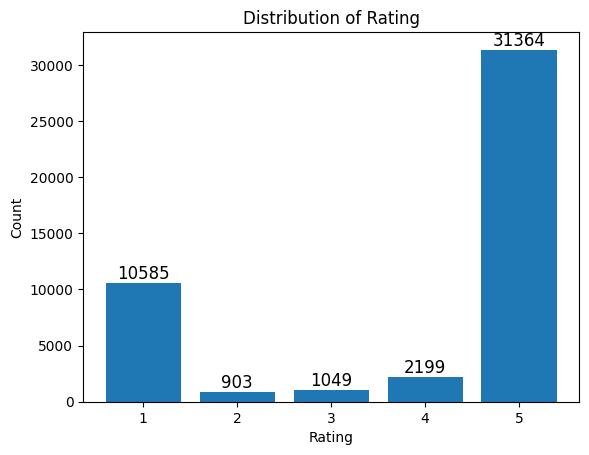

In [80]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))  # Set the figure size
star_counts = test['Rating'].value_counts()

# Create the bar plot and get the Axes object
fig, ax = plt.subplots()  # Create a figure and an axes object
star_plot = ax.bar(star_counts.index, star_counts.values)  # Use ax.bar instead of plt.bar

# Annotate the count on each bar
for p in star_plot.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2, p.get_height()),  # Use ax.annotate
                ha='center', va='bottom', fontsize=12)
plt.title('Distribution of Rating')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()  # Display the plot

In [81]:
# Target variable based on Star Ratings (assuming >3 is positive, else negative)
test['Rating_senti'] = test['Rating'].apply(lambda x: 1 if x > 3 else 0)

In [82]:
Cleaned_Content = [clean_text(review) for review in test['Content']]
test['Cleaned_Content'] = Cleaned_Content
predictions = tfidf_pipeline.predict(test['Cleaned_Content'])
print(predictions)  # Output: Sentiment predictions for new reviews

[0 1 0 ... 0 0 0]


In [83]:
test['tfidf_pred'] = predictions

In [84]:
Cleaned_Content = [clean_text(review) for review in test['Content']]
test['Cleaned_Content'] = Cleaned_Content
predictions = bow_pipeline.predict(test['Cleaned_Content'])
print(predictions)  # Output: Sentiment predictions for new reviews

[1 1 1 ... 0 0 0]


In [85]:
test['bow_pred'] = predictions

In [86]:
# Using Vader for inference on new data
# Set a value for best_threshold
best_threshold = 0.5  # Example value, adjust as needed
vader_predictions = [1 if analyzer.polarity_scores(str(review))['compound'] >= best_threshold else 0 if analyzer.polarity_scores(str(review))['compound'] <= -best_threshold else -1 for review in test['Content']] # Cast review to string using str()
print(vader_predictions)  # Output: Vader sentiment predictions for new reviews

[-1, 1, 1, 1, 0, 0, 0, -1, -1, -1, -1, 1, 1, -1, -1, 0, -1, 0, -1, 1, -1, 1, 0, 1, -1, 1, 1, -1, 1, -1, -1, -1, -1, -1, 0, 0, -1, -1, 1, 1, 1, 0, 0, 1, 0, -1, 1, -1, 0, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, -1, 1, 0, 1, 1, -1, -1, -1, -1, -1, 0, 0, 0, -1, -1, -1, 0, -1, 1, 0, -1, 1, 0, 0, -1, -1, -1, 1, -1, 0, 0, -1, 0, 1, 0, 0, 0, 0, -1, -1, -1, -1, 0, 1, 1, 1, -1, 0, -1, 0, -1, -1, 1, 1, 1, 0, 1, 1, 1, -1, 1, 0, -1, 0, 1, -1, 1, 0, -1, 0, -1, 0, 1, 1, 1, -1, 0, 0, -1, -1, -1, -1, -1, -1, 1, -1, -1, 0, -1, 0, 0, -1, 1, -1, -1, 1, -1, -1, -1, -1, -1, -1, 0, 1, -1, 1, -1, -1, 1, 0, -1, 1, -1, 1, -1, -1, 1, 1, -1, 1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 0, 0, 0, 1, -1, 0, -1, -1, 0, -1, 0, -1, -1, 0, -1, 1, -1, 0, -1, -1, 0, 1, 1, 1, 1, 1, 1, 0, 1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, 1, 0, -1, 1, -1, 1, -1, 0, 0, 1, 0, 0, 1, -1, -1, -1, -1, -1, 0, 1, -1, 0, -1, 1, -1, 0, 1, 1, 1, 1, 0, 1, 1, -1, 0, 0, 0, 0, 1, -1, 1, 0, -1, 0, -1, 0, -1,

In [87]:
test['vadar_pred'] = vader_predictions

In [88]:
test.head(100)

,Id,Username,Location,Total Review,Date of Experience,Content,Rating,Rating_senti,Cleaned_Content,tfidf_pred,bow_pred,vadar_pred
0,0,Christopher Smith,GB,3reviews,30-Jan-24,I have been shopping with Amazon for some time...,4,1,i have been shopping with amazon for some time...,0,1,-1
1,1,blarp.tha.alien,AU,1review,16-May-24,Amazon is Legit a great place to find amazing ...,5,1,amazon is legit a great place to find amazing ...,1,1,1
2,2,Margarita Chavez Villalobos,US,3reviews,13-May-24,Amazon does pretty good on delivering SMALL it...,3,0,amazon does pretty good on delivering small it...,0,1,1
3,3,Mario Alzate,US,1review,18-May-24,"Well, if you educate yourself just a little on...",5,1,well if you educate yourself just a little on ...,1,1,1
4,4,AE user,US,1review,4-May-24,"Found some nice deals, but also ran into a sca...",5,1,found some nice deals but also ran into a scam...,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,li eddy,US,1review,10-May-24,stay away from it! it is a trap. I never ever ...,1,0,stay away from it it is a trap i never ever ha...,0,0,0
96,96,PETER,GB,40reviews,14-May-24,Again another delivery in a very flimsy polyth...,1,0,again another delivery in a very flimsy polyth...,0,0,0
97,97,Bud Nehls,US,2reviews,29-Mar-24,They steal your money. Didn't receive product ...,1,0,they steal your money didnt receive product or...,0,0,-1
98,98,Anders Olsen Hunaeus,DK,9reviews,31-Jan-24,"Don't buy. the product, never arrived . The lo...",1,0,dont buy the product never arrived the local ...,0,0,-1


## **Evaluating the performance of the Model on new dataset (TEAM BRAVO)**

In [92]:
accuracy_bow = accuracy_score(test['Rating_senti'], test['bow_pred'])
f1_bow = f1_score(test['Rating_senti'], test['bow_pred'])
Precision_bow = precision_score(test['Rating_senti'], test['bow_pred'])
Recall_bow = recall_score(test['Rating_senti'], test['bow_pred'])
confusion_matrix(test['Rating_senti'], test['bow_pred'])
print(f"Accuracy: {accuracy_bow:.2f}")
print(f"F1 Score: {f1_bow:.2f}")
print(f"Precision: {Precision_bow:.2f}")
print(f"Recall: {Recall_bow:.2f}")
print(f"Confusion Matrix:\n{confusion_matrix(test['Rating_senti'], test['bow_pred'])}")
print(f"Classification Report:\n{classification_report(test['Rating_senti'], test['bow_pred'])}")


Accuracy: 0.74
F1 Score: 0.79
Precision: 0.97
Recall: 0.67
Confusion Matrix:
[[11807   730]
 [11120 22443]]
Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.94      0.67     12537
           1       0.97      0.67      0.79     33563

    accuracy                           0.74     46100
   macro avg       0.74      0.81      0.73     46100
weighted avg       0.85      0.74      0.76     46100



In [93]:
accuracy_tfidf = accuracy_score(test['Rating_senti'], test['tfidf_pred'])
f1_tfidf = f1_score(test['Rating_senti'], test['tfidf_pred'])
Precision_tfidf = precision_score(test['Rating_senti'], test['tfidf_pred'])
Recall_tfidf = recall_score(test['Rating_senti'], test['tfidf_pred'])
confusion_matrix(test['Rating_senti'], test['tfidf_pred'])
print(f"Accuracy: {accuracy_tfidf:.2f}")
print(f"F1 Score: {f1_tfidf:.2f}")
print(f"Precision: {Precision_tfidf:.2f}")
print(f"Recall: {Recall_tfidf:.2f}")
print(f"Confusion Matrix:\n{confusion_matrix(test['Rating_senti'], test['tfidf_pred'])}")
print(f"Classification Report:\n{classification_report(test['Rating_senti'], test['tfidf_pred'])}")

Accuracy: 0.72
F1 Score: 0.77
Precision: 0.98
Recall: 0.63
Confusion Matrix:
[[12167   370]
 [12326 21237]]
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.97      0.66     12537
           1       0.98      0.63      0.77     33563

    accuracy                           0.72     46100
   macro avg       0.74      0.80      0.71     46100
weighted avg       0.85      0.72      0.74     46100



In [94]:
accuracy_vader = accuracy_score(test['Rating_senti'], test['vadar_pred'])
f1_vader = f1_score(test['Rating_senti'], test['vadar_pred'], average='macro') # Added average='macro'
Precision_vader = precision_score(test['Rating_senti'], test['vadar_pred'], average='macro') # Added average='macro'
Recall_vader = recall_score(test['Rating_senti'], test['vadar_pred'], average='macro') # Added average='macro'
confusion_matrix(test['Rating_senti'], test['vadar_pred'])
print(f"Accuracy: {accuracy_vader:.2f}")
print(f"F1 Score: {f1_vader:.2f}")
print(f"Precision: {Precision_vader:.2f}")
print(f"Recall: {Recall_vader:.2f}")
print(f"Confusion Matrix:\n{confusion_matrix(test['Rating_senti'], test['vadar_pred'])}")
print(f"Classification Report:\n{classification_report(test['Rating_senti'], test['vadar_pred'])}")

Accuracy: 0.50
F1 Score: 0.43
Precision: 0.62
Recall: 0.33
Confusion Matrix:
[[    0     0     0]
 [ 4554  6274  1709]
 [16451   379 16733]]
Classification Report:
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           0       0.94      0.50      0.65     12537
           1       0.91      0.50      0.64     33563

    accuracy                           0.50     46100
   macro avg       0.62      0.33      0.43     46100
weighted avg       0.92      0.50      0.65     46100

